In [ ]:
# Pip installs
!pip install kneed

In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import gc

# Preprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
import hdbscan
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

# Plot
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv("./preproc_data/clean_text_all_subreddits_BoW_reduced.csv", low_memory=False)

# Print length
print(len(df.index))

# Check
df.head()

652146


,subreddit,date,author,id,clean_text,unique_clean_text,link_flair_text,num_comments,score,post_length,...,often,guess,stay,completely,leave,saying,came,either,least,label
0,ADHD,01/01/2019,DirtJunkie133,abd11x,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,NaN,13.0,1,3021,...,0.0,0.0,0.085928,0.0,0.0,0.0,0.0,0.0,0.0,0
1,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,NaN,5.0,1,751,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,ADHD,01/01/2019,Fleetfeathers,abda0t,medication journey current disappointment wan...,medication journey current disappointment want...,NaN,12.0,1,1713,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ADHD,01/01/2019,UnleashedDebs,abdd13,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,NaN,4.0,1,988,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,ADHD,01/01/2019,liluglee,abdj4w,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,NaN,1.0,1,123,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# Doc2Vec
# Tokenize and tag the text
text_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df["clean_text"])]

# Display the tagged docs
print(len(text_docs))

652146


In [4]:
# Instantiate model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs=20)

# Build vocab
model.build_vocab(text_docs)

# Train model
model.train(text_docs, total_examples=model.corpus_count, epochs=model.epochs)

# Generate vectors
post2vec = [model.infer_vector((df['clean_text'][i].split(' '))) for i in range(0,len(df['clean_text']))]

# Display
post2vec

[array([-0.43691748,  0.84149194, -0.16540232, -0.1686126 ,  0.6297153 ,
        -0.45841438,  0.13445951, -0.18052499,  0.8089042 , -0.10247739,
         0.16717632,  0.34983706, -0.2577095 ,  0.00494321, -0.5421135 ,
        -0.07744316,  0.92059034, -0.1471423 , -0.22125655,  0.5564676 ,
        -0.04149542,  0.44988942, -0.25711402,  0.24943231, -0.40897   ,
        -0.7013305 ,  0.8212044 , -1.1025761 ,  1.4542235 ,  1.0992213 ,
         0.312     , -0.75661707,  0.31241047,  0.33020854, -0.01168789,
         0.28024137,  0.04779924, -0.4573477 ,  0.39364466,  0.17482561,
         0.2691723 ,  0.49088973,  0.03700111, -0.32302773,  0.5870624 ,
        -0.30371627,  0.49589577, -0.45575008,  0.18863355,  0.35631827,
        -0.12349666,  0.07938639, -1.3477963 ,  0.08815394,  0.29933155,
         0.51042795,  0.68580383, -1.6526785 ,  0.12845345, -0.03751813,
        -0.25235537,  0.15922718,  0.76525426,  0.06904265], dtype=float32),
 array([ 0.38644263,  0.34515664, -0.3462557 , 

In [5]:
# Convert post2vec to df
p2v = pd.DataFrame(post2vec)

# Add prefix to column names
p2v = p2v.add_prefix("feature_")

# Display
p2v

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,-0.436917,0.841492,-0.165402,-0.168613,0.629715,-0.458414,0.134460,-0.180525,0.808904,-0.102477,...,0.299332,0.510428,0.685804,-1.652678,0.128453,-0.037518,-0.252355,0.159227,0.765254,0.069043
1,0.386443,0.345157,-0.346256,0.421453,0.158651,-1.024548,0.244154,-0.095248,1.391719,-0.399130,...,0.877196,-0.162841,-0.540606,-0.150722,0.928507,-0.031116,0.335095,-0.006605,-0.937683,-1.389813
2,-1.250938,0.000568,-1.190970,0.202914,0.858389,0.407098,-1.030759,0.929476,-0.224365,1.144073,...,0.574246,0.272370,1.032429,-1.337527,0.667623,0.400174,0.831625,0.345661,0.394120,-0.259718
3,0.258038,0.756908,-0.741313,-0.250327,-0.168593,-0.164526,0.050273,0.700734,0.218669,0.054656,...,1.307342,-1.477269,0.028247,-0.703448,0.413334,-0.083348,-0.643955,-0.406943,0.023596,-0.731947
4,0.665023,0.039641,-0.708087,-0.599019,-0.125081,0.049626,0.138491,0.017446,-0.104903,0.948720,...,-0.321208,-0.081452,-0.145260,-0.533126,-0.085388,-0.120506,-0.483124,-0.229370,-0.199331,0.099358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652141,-0.212362,0.042490,-0.139161,-0.281235,-0.298355,0.126758,-0.012611,0.341202,0.218949,-0.273291,...,-0.211571,-0.005762,-0.212123,0.053458,-0.018678,-0.097985,0.316801,-0.133307,0.299745,0.133284
652142,-0.583645,-0.396657,0.199376,0.135760,-0.530136,-0.111254,0.308683,0.609496,0.073060,-0.235160,...,-0.277683,-0.390176,0.534355,0.376532,-0.480725,-0.267389,-0.426534,0.390053,0.804430,0.673449
652143,-0.037949,-0.187201,-0.225484,0.169566,-0.017758,-0.167705,-0.207173,0.269107,-0.163409,-0.151459,...,-0.182303,-0.103705,-0.318531,-0.182365,-0.198033,-0.097358,0.349932,-0.021822,-0.072343,-0.048637
652144,0.514411,0.238256,-0.715169,-0.609486,0.810955,0.044140,0.505706,0.250849,0.061923,-0.563944,...,-1.146643,-0.202803,-0.861669,0.168041,0.647776,-0.810466,-0.454097,-0.182311,0.635879,-0.883899


In [6]:
# Concatenate
df = pd.concat([df, p2v], axis=1)

# Check
display(df.head())

# Save to csv
df.to_csv("./preproc_data/clean_text_all_subreddits_d2v.csv", index=False)

,subreddit,date,author,id,clean_text,unique_clean_text,link_flair_text,num_comments,score,post_length,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,ADHD,01/01/2019,DirtJunkie133,abd11x,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,NaN,13.0,1,3021,...,0.299332,0.510428,0.685804,-1.652678,0.128453,-0.037518,-0.252355,0.159227,0.765254,0.069043
1,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,NaN,5.0,1,751,...,0.877196,-0.162841,-0.540606,-0.150722,0.928507,-0.031116,0.335095,-0.006605,-0.937683,-1.389813
2,ADHD,01/01/2019,Fleetfeathers,abda0t,medication journey current disappointment wan...,medication journey current disappointment want...,NaN,12.0,1,1713,...,0.574246,0.272370,1.032429,-1.337527,0.667623,0.400174,0.831625,0.345661,0.394120,-0.259718
3,ADHD,01/01/2019,UnleashedDebs,abdd13,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,NaN,4.0,1,988,...,1.307342,-1.477269,0.028247,-0.703448,0.413334,-0.083348,-0.643955,-0.406943,0.023596,-0.731947
4,ADHD,01/01/2019,liluglee,abdj4w,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,NaN,1.0,1,123,...,-0.321208,-0.081452,-0.145260,-0.533126,-0.085388,-0.120506,-0.483124,-0.229370,-0.199331,0.099358


# Clustering

In [2]:
# Load data
df = pd.read_csv("./preproc_data/clean_text_all_subreddits_d2v.csv", low_memory=False)

# Display
display(df.head())

,subreddit,date,author,id,clean_text,unique_clean_text,link_flair_text,num_comments,score,post_length,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,ADHD,01/01/2019,DirtJunkie133,abd11x,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,NaN,13.0,1,3021,...,0.299332,0.510428,0.685804,-1.652678,0.128453,-0.037518,-0.252355,0.159227,0.765254,0.069043
1,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,NaN,5.0,1,751,...,0.877196,-0.162841,-0.540606,-0.150722,0.928507,-0.031116,0.335095,-0.006605,-0.937683,-1.389813
2,ADHD,01/01/2019,Fleetfeathers,abda0t,medication journey current disappointment wan...,medication journey current disappointment want...,NaN,12.0,1,1713,...,0.574246,0.272370,1.032429,-1.337527,0.667623,0.400174,0.831625,0.345661,0.394120,-0.259718
3,ADHD,01/01/2019,UnleashedDebs,abdd13,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,NaN,4.0,1,988,...,1.307342,-1.477269,0.028247,-0.703448,0.413334,-0.083348,-0.643955,-0.406943,0.023596,-0.731947
4,ADHD,01/01/2019,liluglee,abdj4w,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,NaN,1.0,1,123,...,-0.321208,-0.081452,-0.145260,-0.533126,-0.085388,-0.120506,-0.483124,-0.229370,-0.199331,0.099358


In [3]:
# Drop label column
df_copy = df.drop(columns=["label"])

# Select only numeric columns
df_copy = df_copy.select_dtypes(['number'])

# Print column names
for i in range(len(df_copy.columns)):
    print(i, ":", df_copy.columns[i])
    
# Drop all BoW columns
df_copy = df_copy.iloc[:, list(range(9)) + list(range(248, len(df_copy.columns)))]

# Scale data
df_copy[df_copy.columns] = StandardScaler().fit_transform(df_copy)

# Drop all rows with NaN
df_copy = df_copy.dropna()

# Disply
display(df_copy.head())

0 : num_comments
1 : score
2 : post_length
3 : word_count
4 : norm_noun
5 : norm_verb
6 : norm_adj
7 : norm_adv
8 : compound_sent
9 : like
10 : im
11 : feel
12 : get
13 : know
14 : time
15 : anxiety
16 : really
17 : want
18 : day
19 : thing
20 : dont
21 : people
22 : year
23 : life
24 : help
25 : friend
26 : even
27 : one
28 : think
29 : make
30 : would
31 : go
32 : ive
33 : anyone
34 : work
35 : going
36 : something
37 : feeling
38 : thought
39 : much
40 : need
41 : adhd
42 : got
43 : never
44 : cant
45 : always
46 : someone
47 : good
48 : way
49 : back
50 : anything
51 : also
52 : bad
53 : still
54 : take
55 : could
56 : week
57 : school
58 : first
59 : mental
60 : else
61 : lot
62 : job
63 : month
64 : talk
65 : happy
66 : say
67 : today
68 : see
69 : love
70 : getting
71 : since
72 : right
73 : depression
74 : everything
75 : started
76 : better
77 : last
78 : every
79 : health
80 : new
81 : ever
82 : hard
83 : long
84 : family
85 : tell
86 : person
87 : keep
88 : made
89 : well
90

,num_comments,score,post_length,word_count,norm_noun,norm_verb,norm_adj,norm_adv,compound_sent,feature_0,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,0.053725,-0.037219,1.872750,2.286707,-0.000385,0.386145,-0.302998,0.029174,1.273688,-0.730425,...,0.515039,1.117292,0.749695,-2.491639,0.333914,-0.130851,-0.663914,0.531010,0.956422,-0.169411
1,-0.019409,-0.037219,-0.155580,-0.125836,0.754612,-0.960765,-0.645358,-0.129778,-1.282187,0.779475,...,1.552497,-0.188002,-1.413258,0.036289,1.786693,-0.119035,0.462546,0.237102,-1.983925,-2.902682
2,0.044584,-0.037219,0.704003,1.029466,0.148139,-0.081685,0.122210,-0.308534,0.643440,-2.223199,...,1.008601,0.655758,1.361018,-1.961210,1.312967,0.676921,1.414665,0.861431,0.315610,-0.785368
3,-0.028551,-0.037219,0.056189,0.112020,-0.197461,0.434426,0.135248,-0.203083,1.146846,0.544004,...,2.324751,-2.736335,-0.410003,-0.893999,0.851215,-0.215431,-1.414824,-0.472427,-0.324150,-1.670123
4,-0.055976,-0.037219,-0.716721,-0.839405,1.525338,0.070463,-1.521700,-1.687508,1.102451,1.290343,...,-0.599035,-0.030210,-0.716008,-0.607331,-0.054391,-0.284007,-1.106423,-0.157710,-0.709063,-0.112613


In [4]:
# Initialize PCA
pca = PCA(2)
 
# Transform the data
df_pca = pca.fit_transform(df_copy)

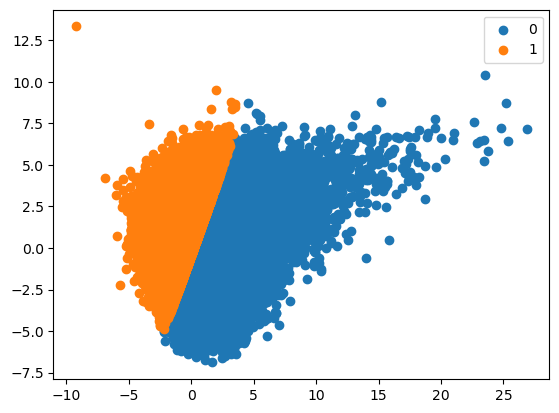

In [5]:
# Run K-Means
km_label = KMeans(n_clusters=2, random_state=0).fit_predict(df_pca.data)

# Get unique labels
kmean_labels = np.unique(km_label)

# Plot the results:
for i in kmean_labels:
    plt.scatter(df_pca[km_label == i , 0], df_pca[km_label == i, 1], label = i)
plt.legend()

plt.show()

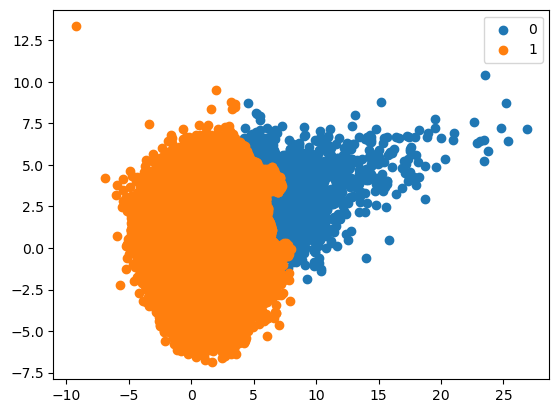

In [6]:
# Run BIRCH (Works with high dimensional data, had to use pca due to memory)
birch_label = Birch(n_clusters=2).fit_predict(df_pca.data)
birch_labels = np.unique(birch_label)

# Plot
for i in birch_labels:
    plt.scatter(df_pca[birch_label == i, 0], df_pca[birch_label == i, 1], label = i)
plt.legend()

plt.show()

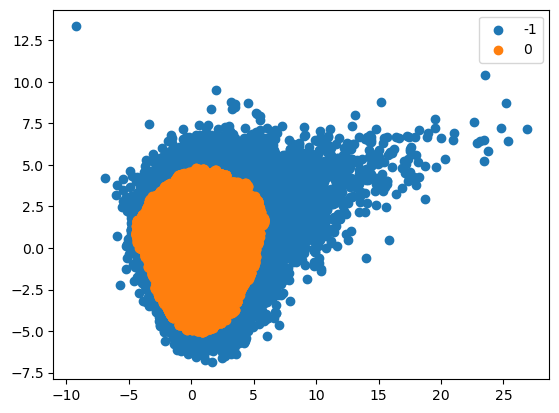

In [7]:
# Run HDBSCAN (Works with high dimensional data)
clusterer = hdbscan.HDBSCAN(min_cluster_size = 200, min_samples=1, allow_single_cluster = True)
clusters = clusterer.fit(df_pca.data)
hdbscan_label = clusterer.labels_

hdbscan_labels = np.unique(hdbscan_label)

for i in hdbscan_labels:
    plt.scatter(df_pca[hdbscan_label == i, 0], df_pca[hdbscan_label == i, 1], label = i)
plt.legend()

plt.show()

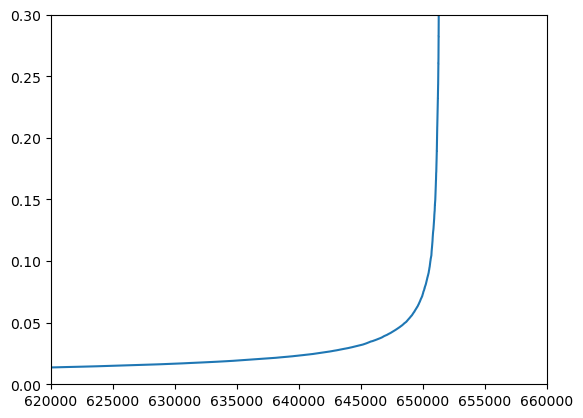

651084
0.19109266209165082


In [10]:
# Find optimal epsilon for DBSCAN
# Source: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_pca.data)
distances, indices = nbrs.kneighbors(df_pca.data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

# Zoom in
plt.xlim([620000, 660000])
plt.ylim([0, 0.3])

plt.show()

# Finds point of maximum curvature, returns index
kn = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
print(kn.elbow)

# Epsilon value is at this index, round up to 0.2
print(distances[kn.elbow])

In [13]:
# Clear some memory
del pca
del clusterer
del clusters
del neigh
del nbrs
del distances
del kn
gc.collect()

11503

C:\Users\denni\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


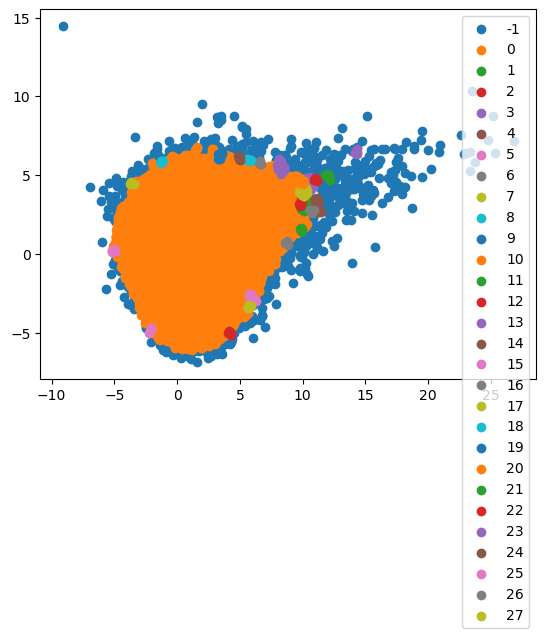

In [18]:
# Run DBSCAN
dbscan_label = DBSCAN(eps=0.2).fit_predict(df_pca.data)
dbscan_labels = np.unique(dbscan_label)

# Plot
for i in dbscan_labels:
    plt.scatter(df_pca[dbscan_label == i, 0], df_pca[dbscan_label == i, 1], label = i)
plt.legend()

plt.show()

In [ ]:
# Run Spectral Clustering (Works with high dimensional data -- Doesn't work, ran out of memory)
# sc_label = SpectralClustering(n_clusters=2,
#                               assign_labels='discretize',
#                               random_state=0).fit_predict(df_pca.data)

# sc_labels = np.unique(sc_label)

# for i in sc_labels:
#     plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
# plt.legend()

# plt.show()

In [8]:
# Reset index
df_copy = df_copy.reset_index()
df = df.reset_index()

# Add clustering labels to df_copy
df_copy["kmeans_label"] = list(km_label)
df_copy["birch_label"] = list(birch_label)
df_copy["hdbscan_label"] = list(hdbscan_label)
#df_copy["dbscan_label"] = list(dbscan_label)
# df_copy["spectralClustering_label"] = list(sc_label)

# Convert kmeans_label to int
df_copy["kmeans_label"] = df_copy["kmeans_label"].astype(int)
df_copy["birch_label"] = df_copy["birch_label"].astype(int)
df_copy["hdbscan_label"] = df_copy["hdbscan_label"].astype(int)
#df_copy["dbscan_label"] = df_copy["dbscan_label"].astype(int)
# df_copy["spectralClustering_label"] = df_copy["spectralClustering_label"].astype(int)

# Select columns
df_copy = df_copy[["index", "kmeans_label", "birch_label", "hdbscan_label"]]

# Display
display(df_copy)

,index,kmeans_label,birch_label,hdbscan_label
0,0,0,1,0
1,1,1,1,0
2,2,0,1,0
3,3,0,1,0
4,4,1,1,0
...,...,...,...,...
651425,652141,1,1,0
651426,652142,1,1,0
651427,652143,1,1,0
651428,652144,1,1,0


In [9]:
# Merge with original data frame
df_merged = df_copy.merge(df)

# Check
df_merged.head()

,index,kmeans_label,birch_label,hdbscan_label,subreddit,date,author,id,clean_text,unique_clean_text,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,0,0,1,0,ADHD,01/01/2019,DirtJunkie133,abd11x,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,...,0.299332,0.510428,0.685804,-1.652678,0.128453,-0.037518,-0.252355,0.159227,0.765254,0.069043
1,1,1,1,0,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,...,0.877196,-0.162841,-0.540606,-0.150722,0.928507,-0.031116,0.335095,-0.006605,-0.937683,-1.389813
2,2,0,1,0,ADHD,01/01/2019,Fleetfeathers,abda0t,medication journey current disappointment wan...,medication journey current disappointment want...,...,0.574246,0.272370,1.032429,-1.337527,0.667623,0.400174,0.831625,0.345661,0.394120,-0.259718
3,3,0,1,0,ADHD,01/01/2019,UnleashedDebs,abdd13,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,...,1.307342,-1.477269,0.028247,-0.703448,0.413334,-0.083348,-0.643955,-0.406943,0.023596,-0.731947
4,4,1,1,0,ADHD,01/01/2019,liluglee,abdj4w,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,...,-0.321208,-0.081452,-0.145260,-0.533126,-0.085388,-0.120506,-0.483124,-0.229370,-0.199331,0.099358


In [11]:
# Select columns and display (can be easily merged back into original dataframe)
check = df_merged[["index", "subreddit", "clean_text", "label", "kmeans_label", "birch_label", "hdbscan_label"]]
display(check)

# Save to csv
check.to_csv("./preproc_data/clustered_d2v.csv", index=False)

,index,subreddit,clean_text,label,kmeans_label,birch_label,hdbscan_label
0,0,ADHD,recently diagnosed need talk others diagnosed ...,0,0,1,0
1,1,ADHD,really annoyed family drunk friend family host...,0,1,1,0
2,2,ADHD,medication journey current disappointment wan...,0,0,1,0
3,3,ADHD,wearable rem sleep detected gaming sleeping hy...,0,0,1,0
4,4,ADHD,picking friend carpool nye party texted way dr...,0,1,1,0
...,...,...,...,...,...,...,...
651425,652141,sad,sad one talk new year,1,1,1,0
651426,652142,sad,worst new year eve ever depression hit bad las...,0,1,1,0
651427,652143,sad,check sad song,1,1,1,0
651428,652144,sad,zoom wedding tomorrow story let call groom bob...,1,1,1,0


In [12]:
# Basic statistics
print("The number of 1s in label is", len(check[check["label"] == 1].index))
print("The number of 1s in kmeans_label is", len(check[check["kmeans_label"] == 1].index))
print("The number of 1s in birch_label is", len(check[check["birch_label"] == 1].index))
print("The number of 0s in hdbscan_label is", len(check[check["hdbscan_label"] == 0].index))
print("")
print("The number of 0s in label is", len(check[check["label"] == 0].index))
print("The number of 0s in kmeans_label is", len(check[check["kmeans_label"] == 0].index))
print("The number of 0s in birch_label is", len(check[check["birch_label"] == 0].index))
print("The number of -1s in hdbscan_label is", len(check[check["hdbscan_label"] == -1].index))

# Note: it's easier to find basic statistics filtering in Excel (i.e. for when birch and hdscan are the same)

The number of 1s in label is 85428
The number of 1s in kmeans_label is 360694
The number of 1s in birch_label is 648968
The number of 0s in hdbscan_label is 638696

The number of 0s in label is 566002
The number of 0s in kmeans_label is 290736
The number of 0s in birch_label is 2462
The number of -1s in hdbscan_label is 12734
